In [2]:
import sys
sys.path.append('..')
from jaewook_header import *
%matplotlib inline

Using TensorFlow backend.


In [3]:
images=np.load('data1-L-images-conn.npy')
masks=np.load('data1-L-masks-conn.npy')

IMG_HEIGHT,IMG_WIDTH=images.shape[1:3]
BATCH_SIZE=8

In [4]:
from sklearn.model_selection import train_test_split
images_train, images_val, masks_train, masks_val =\
train_test_split(images,masks,test_size=.1,random_state=seed)

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


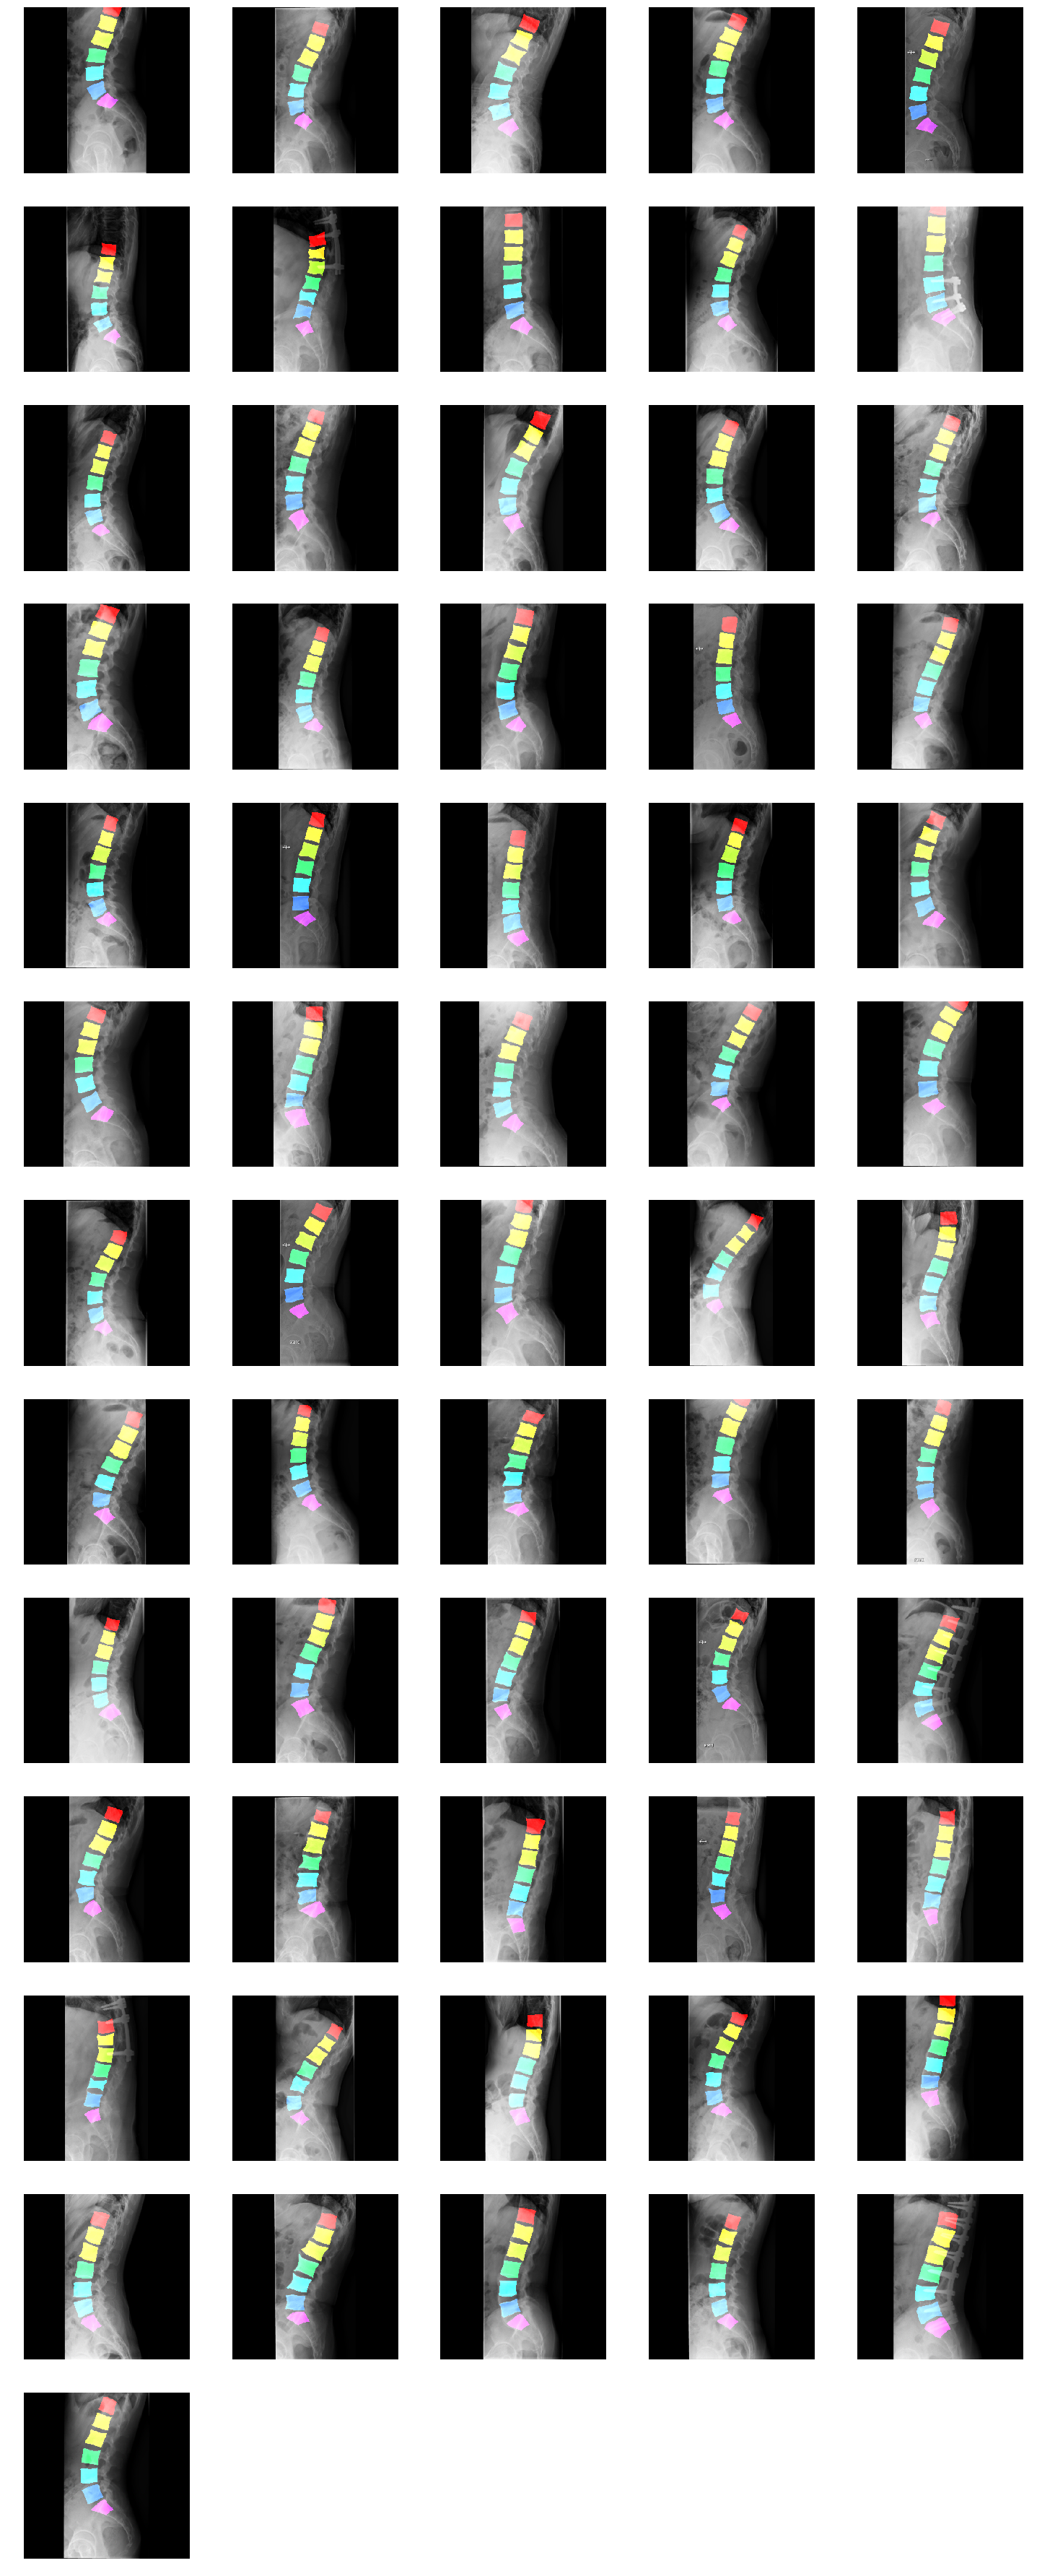

In [5]:
imshow2(overlay(images_train,level(masks_train)))

# Augmentation

In [5]:
data_gen_args=dict(rotation_range=45,
                   width_shift_range=.2,
                   height_shift_range=.2,
                   shear_range=.7,
                   zoom_range=[.9,2.2],
                   horizontal_flip=True,
                   fill_mode='constant')

# train

images_train_datagen=ImageDataGenerator(**data_gen_args)
masks_train_datagen=ImageDataGenerator(**data_gen_args)

images_train_generator=images_train_datagen.flow(images_train,
                                                 batch_size=BATCH_SIZE,
                                                 seed=seed)
masks_train_generator=masks_train_datagen.flow(masks_train,
                                               batch_size=BATCH_SIZE,
                                               seed=seed)

train_generator=zip(images_train_generator,masks_train_generator)

# validation

images_val_datagen=ImageDataGenerator()
masks_val_datagen=ImageDataGenerator()

images_val_generator=images_val_datagen.flow(images_val,seed=seed)
masks_val_generator=masks_val_datagen.flow(masks_val,seed=seed)

val_generator=zip(images_val_generator,masks_val_generator)

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\keras_preprocessing\image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (61, 512, 512, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\keras_preprocessing\image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (7, 512, 512, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


# Sanity Check

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


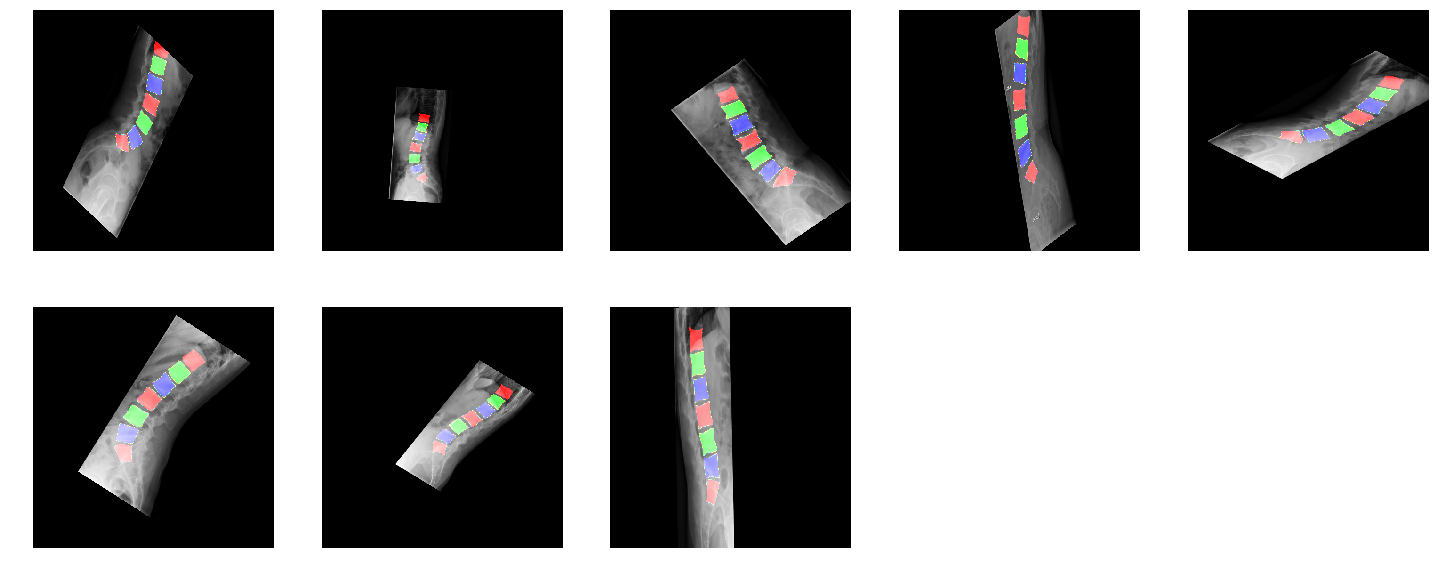

In [6]:
images_preview,masks_preview=next(train_generator)
imshow2(overlay(images_preview,level(masks_preview)))

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


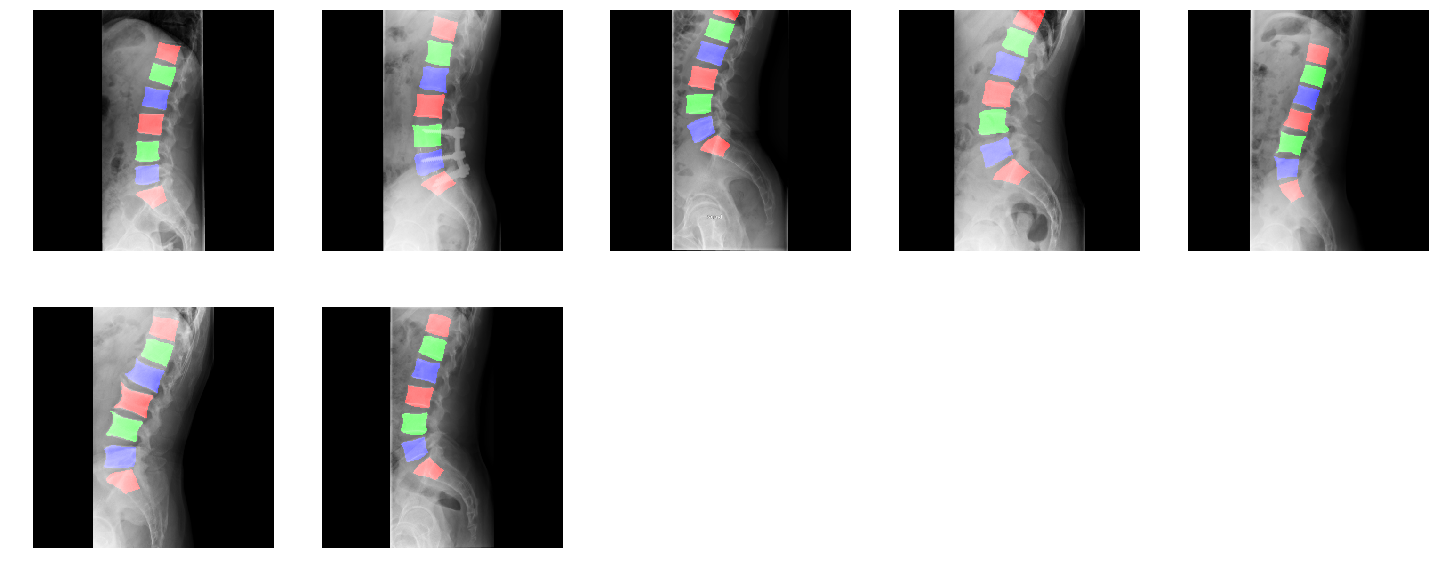

In [7]:
images_preview,masks_preview=next(val_generator)
imshow2(overlay(images_preview,level(masks_preview)))

In [8]:
# 남의 코드
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Model

## Second Trial

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512, 512, 7)  5158455     lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

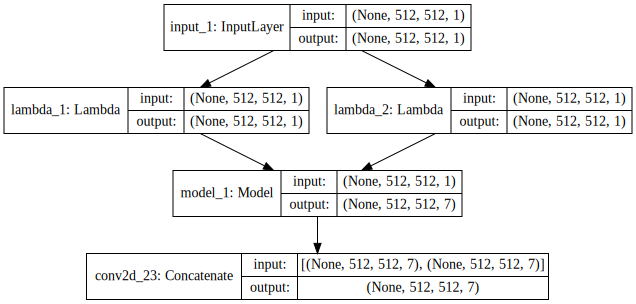

In [9]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
# s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization() (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization() (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization() (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization() (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c4m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c4m = BatchNormalization() (c4m)
c4m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4m)
p4m = MaxPooling2D(pool_size=(2, 2)) (c4m)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4m)
c5 = BatchNormalization() (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6m = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6m = concatenate([u6m, c4m])
c6m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6m)
c6m = BatchNormalization() (c6m)
c6m = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6m)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6m)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization() (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization() (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization() (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization() (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(7, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model=multi_gpu_model(model,gpus=2)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [10]:
checkpointer = ModelCheckpoint('1201-unet.h5',
                               monitor='val_mean_iou',
                               mode='max',
                               verbose=1,
                               save_best_only=True)

results=model.fit_generator(train_generator,
                            validation_data=val_generator,
                            validation_steps=1,
                            steps_per_epoch=100,
                            epochs=1000,
                            callbacks=[checkpointer])

Epoch 1/1000
100/100 [==============================] - 84s 843ms/step - loss: 0.3107 - mean_iou: 0.4619 - val_loss: 0.0662 - val_mean_iou: 0.4857

Epoch 00001: val_mean_iou improved from -inf to 0.48573, saving model to 1201-unet.h5
Epoch 2/1000
100/100 [==============================] - 76s 759ms/step - loss: 0.0235 - mean_iou: 0.4907 - val_loss: 0.0436 - val_mean_iou: 0.4937

Epoch 00002: val_mean_iou improved from 0.48573 to 0.49371, saving model to 1201-unet.h5
Epoch 3/1000
100/100 [==============================] - 77s 765ms/step - loss: 0.0170 - mean_iou: 0.4951 - val_loss: 0.0452 - val_mean_iou: 0.4962

Epoch 00003: val_mean_iou improved from 0.49371 to 0.49617, saving model to 1201-unet.h5
Epoch 4/1000
100/100 [==============================] - 77s 766ms/step - loss: 0.0152 - mean_iou: 0.4968 - val_loss: 0.0353 - val_mean_iou: 0.4973

Epoch 00004: val_mean_iou improved from 0.49617 to 0.49731, saving model to 1201-unet.h5
Epoch 5/1000
100/100 [==============================] -

KeyboardInterrupt: 

C:\Users\snu\AppData\Local\Continuum\anaconda3\envs\venv\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


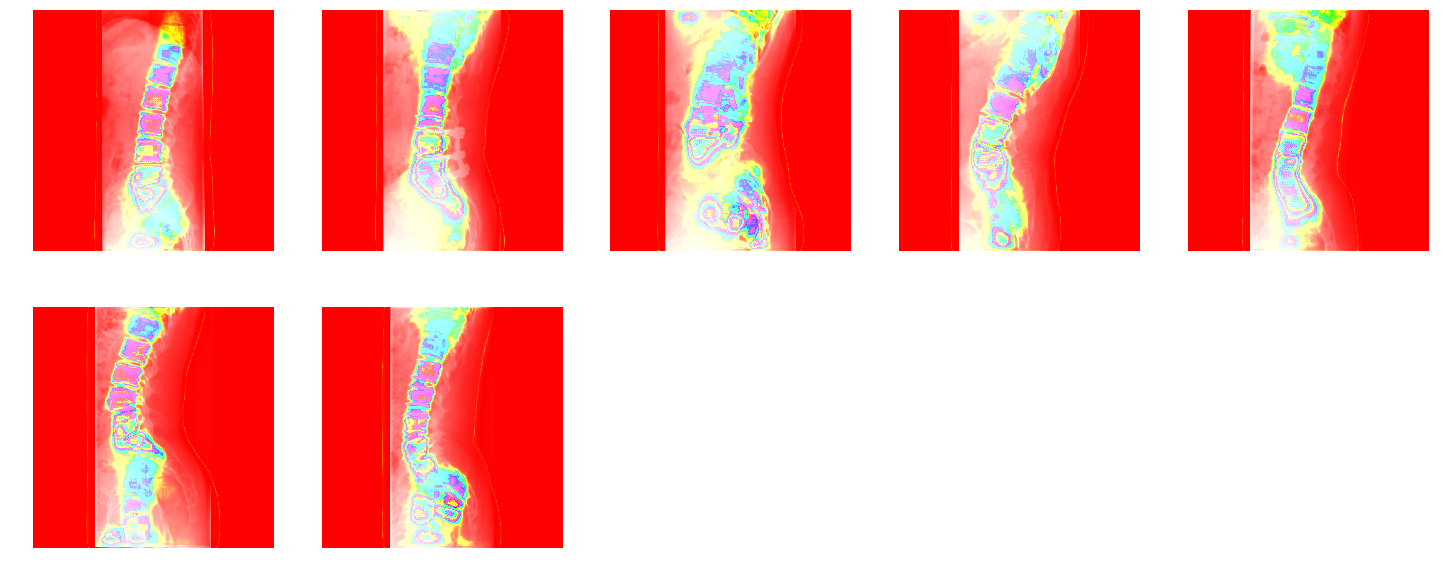

In [12]:
model=load_model('1201-unet.h5',custom_objects={'mean_iou':mean_iou})
imshow2(overlay(images_val,level(model.predict(images_val))))

In [14]:
model.predict(images_val)

array([[[[4.51360419e-02, 2.58052163e-02, 2.51546539e-02, ...,
          6.81739822e-02, 1.27589842e-02, 3.19211707e-02],
         [4.85929614e-03, 1.72721862e-03, 2.81012501e-03, ...,
          5.44043072e-03, 3.96877585e-04, 4.02972847e-03],
         [9.65452346e-04, 4.22309968e-04, 9.12079122e-04, ...,
          1.81151344e-03, 1.11188470e-04, 1.20944902e-03],
         ...,
         [3.72019014e-04, 1.36731571e-04, 2.58136832e-04, ...,
          5.75284124e-04, 2.06275145e-05, 3.53236304e-04],
         [6.54615753e-04, 2.37779663e-04, 6.90318411e-04, ...,
          1.83961669e-03, 5.66535309e-05, 5.38681168e-04],
         [3.68017307e-03, 2.64805020e-03, 9.39661916e-03, ...,
          6.87827682e-03, 1.13449374e-03, 9.60471947e-03]],

        [[2.09253980e-03, 1.53981405e-03, 1.15909614e-03, ...,
          3.35209095e-03, 1.14329986e-03, 1.74772588e-03],
         [4.28075618e-05, 2.37258646e-05, 2.66767729e-05, ...,
          1.68356943e-04, 1.47500632e-05, 7.40563264e-05],
        

# failed